In [1]:
# package importing

import cupy as cp
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from numba import jit, prange

# for getContour function 
import cv2

## Scaling Parameters

In [2]:
width, height, distance, xShift, yShift = np.float64(280), np.float64(175), np.float64(12), np.float64(0), np.float64(0)

def setScale(*args):
    # physical size in um: width, height, distance (positive if sample at +z)
    global width, height, distance, xShift, yShift

    if len(args)==3:
        width, height, distance = np.float64(args[0]), np.float64(args[1]), np.float64(args[2])
    elif len(args)==5:
        width, height, distance, xShift, yShift = np.float64(args[0]), np.float64(args[1]), np.float64(args[2]), np.float64(args[3]), np.float64(args[4])
    else:
        width = np.float64(input('physical size: width:\t'))
        height = np.float64(input('physical size: height:\t'))
        distance = np.float64(input('physical size: distance:\t'))
        xShift = np.float64(input('physical size: xShift:\t'))
        yShift = np.float64(input('physical size: yShift:\t'))
    
    return None

In [3]:
setScale(280,175,12.,0.,0.)

## Loading B Field Data

In [4]:
bExp = cp.zeros(shape=(1,1,1),dtype=cp.float64)
bPixelX, bPixelY = 1,1

def loadB():
    # loading magnetic field data (in .npy format)
    global bExp, bPixelX, bPixelY

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()
    bX = np.load(filedialog.askopenfilename(title="Select Bx Data (in .npy format)"))
    bPixelX, bPixelY = bX.shape

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()
    bY = np.load(filedialog.askopenfilename(title="Select By Data (in .npy format)"))

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()
    bZ = np.load(filedialog.askopenfilename(title="Select Bz Data (in .npy format)"))

    bExp = cp.asarray(np.concatenate((bX[:,:,np.newaxis],bY[:,:,np.newaxis],bZ[:,:,np.newaxis]),axis=2))

    return None

In [5]:
loadB()

## Selecting B Region of Interest

In [6]:
def bShow(bMap):

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    bRMSFull = np.sqrt(cp.sum(bMap**2)/bPixelX/bPixelY/3)
    HB = min(2*bRMSFull, cp.max(bMap))
    LB = max(-2*bRMSFull,cp.min(bMap))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Bx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('By')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Bz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bPixelX)
    yTicks, yTickLabels = makeYTicks(bPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    return None

In [7]:
bStartX, bStartY, bEndX, bEndY, bCropX, bCropY = 0,0,bPixelX,bPixelY,bPixelX,bPixelY
bRMS = np.sqrt(cp.sum(bExp**2)/bPixelX/bPixelY/3)
bCropped = cp.copy(bExp)

def bCropping(ifBalanced=False):
    # selecting region of interest
    global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped

    bShow(bExp)
    plt.savefig('bShow.png', format='png')

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.title("Selecting B Region")

    canvas = tk.Canvas(root)
    image = tk.PhotoImage(master=canvas, file='bShow.png')
    image_label = tk.Label(root, image=image)
    image_label.image = image
    image_label.pack()

    label_start_x = tk.Label(root, text="StartX=")
    label_start_x.pack()

    entry_start_x = tk.Entry(root)
    entry_start_x.pack()

    label_start_y = tk.Label(root, text="StartY=")
    label_start_y.pack()

    entry_start_y = tk.Entry(root)
    entry_start_y.pack()

    label_end_x = tk.Label(root, text="EndX=")
    label_end_x.pack()

    entry_end_x = tk.Entry(root)
    entry_end_x.pack()

    label_end_y = tk.Label(root, text="EndY=")
    label_end_y.pack()

    entry_end_y = tk.Entry(root)
    entry_end_y.pack()

    def on_enter_button_clicked():
        # Get values from entry widgets, remain unchanged if empty
        global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped
        bStartX = int(entry_start_x.get()) if entry_start_x.get() != '' else bStartX
        bStartY = int(entry_start_y.get()) if entry_start_y.get() != '' else bStartY
        bEndX = int(entry_end_x.get()) if entry_end_x.get() != '' else bEndX
        bEndY = int(entry_end_y.get()) if entry_end_y.get() != '' else bEndY
        bCropX = bEndX - bStartX
        bCropY = bEndY - bStartY
        bCropped = bExp[bStartX:bEndX,bStartY:bEndY,:]
        if ifBalanced:
            bAVG = cp.sum(bCropped) / bCropX / bCropY
            bCropped -= bAVG
        bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
        
        root.destroy()
        root.quit()

        print(f"StartX={bStartX}, StartY={bStartY}, EndX={bEndX}, EndY={bEndY}")
        return None
    
    def on_cancel_button_clicked():
        root.destroy()
        root.quit()
        return None
    
    root.protocol("WM_DELETE_WINDOW", on_cancel_button_clicked)

    button_enter = tk.Button(root, text="Enter", command=on_enter_button_clicked)
    button_enter.pack()
    button_cancel = tk.Button(root, text="Cancel", command=on_cancel_button_clicked)
    button_cancel.pack()

    root.mainloop()

    os.remove('bShow.png')
    
    return None

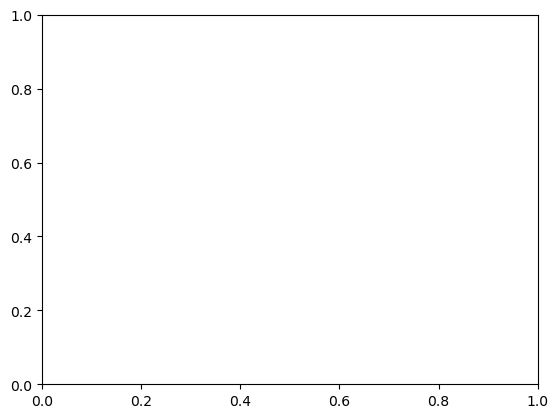

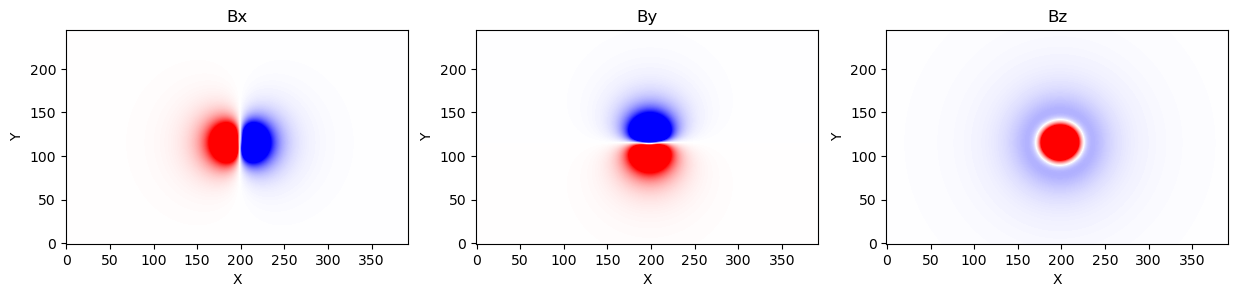

In [8]:
bCropping()

## Selecting Magnetization Region

In [9]:
mPixelX, mPixelY, NofP, listX, listY, mRes = 1,1,1,np.array([0]),np.array([0]),cp.zeros(shape=(1,3),dtype=cp.float64)
mAVG = 1

def spinAllocate(magFactor=1):
    global mPixelX, mPixelY, NofP, listX, listY, mRes, mAVG

    root = tk.Tk()
    image_path = filedialog.askopenfilename(title="Select camera image")
    root.withdraw()
    img_ = cv2.imread(image_path)  # The image should be larger than img_w * img_h
    mPixelY, mPixelX = img_.shape[0:2] # Original image height and width
    cv2.destroyAllWindows()
    
    def main():
        global all_polygons, current_polygon, img, img_copy
        all_polygons = []
        current_polygon = []
        def draw_polygons(event, x, y, flags, param):
            global all_polygons, current_polygon, img, img_copy
            if event == cv2.EVENT_LBUTTONDOWN:  
                current_polygon.append((x, y))
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
                if len(current_polygon) > 1:
                    cv2.line(img, current_polygon[-2], current_polygon[-1], (255, 0, 0), 2)
                cv2.imshow('image', img)
            elif event == cv2.EVENT_RBUTTONDOWN:  
                if len(current_polygon) > 2:
                    cv2.line(img, current_polygon[-1], current_polygon[0], (255, 0, 0), 2)
                    all_polygons.append(current_polygon.copy())
                    current_polygon = []
                    img = img_copy.copy()
                    for polygon in all_polygons:
                        for i in range(len(polygon)):
                            cv2.circle(img, polygon[i], 2, (0, 255, 0), -1)
                            cv2.line(img, polygon[i], polygon[(i + 1) % len(polygon)], (255, 0, 0), 2)
                    cv2.imshow('image', img)
            return None
        def get_polygon_mask(img_shape, polygons):
            mask = np.zeros(img_shape[:2], dtype=np.uint8)
            for vertices in polygons:
                vertices = np.array([vertices], dtype=np.int32)
                cv2.fillPoly(mask, vertices, 1)
            return mask
        def get_pixels_within_polygons(img, polygons):
            mask = get_polygon_mask(img.shape, polygons)
            points = np.column_stack(np.where(mask == 1))
            return points
        
        img = cv2.imread(image_path)
        if img is None:
            print(f'Failed to load image: {image_path}')
            return
        
        img_copy = img.copy()
        cv2.namedWindow('image')
        cv2.setMouseCallback('image', draw_polygons)
        cv2.imshow('image', img)

        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

        cv2.destroyAllWindows()
        if all_polygons:
            return get_pixels_within_polygons(img, all_polygons)

    selected = main()
    listX, listY = [],[]
    selected_N = list(set((round((y+0.5)*magFactor-0.5),round((mPixelY-1-x+0.5)*magFactor-0.5)) for x,y in selected))
    mPixelX, mPixelY = int(magFactor*mPixelX), int(magFactor*mPixelY)
    NofP = len(selected_N)
    for i in range(NofP):
        listX.append(selected_N[i][0])
        listY.append(selected_N[i][1])
    listX, listY = np.array(listX), np.array(listY)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

    return None

def spinRegionLoad():
    global mPixelX, mPixelY, NofP, listX, listY, mRes, mAVG

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()
    image_path = filedialog.askopenfilename(title="Select weight matrix")
    root.destroy()

    weight = np.load(image_path)
    points = np.column_stack(np.where(weight == 1))
    listX, listY = [],[]
    mPixelX, mPixelY = weight.shape
    NofP = len(points)
    for i in range(NofP):
        listX.append(points[i][0])
        listY.append(points[i][1])
    listX, listY = np.array(listX), np.array(listY)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

    return None

def spinRegionSave(filename=None):
    if filename == None:
        filename = 'weight.npy'
    mMat = cp.zeros(shape=(mPixelX,mPixelY),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i]] = 1
    cp.save(filename,mMat)
    
    return None

In [10]:
spinAllocate(0.32)

AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
spinRegionLoad()

## Generating Coefficient Matrix

In [12]:
matrixA = cp.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=cp.float64)

@jit(nopython=True, parallel=True)
def matrixAGenerate_(bCropX,bCropY,NofP,width,height,bPixelX,bPixelY,mPixelX,mPixelY,bStartX,bStartY,xShift,yShift,distance,listX,listY):
    
    rPosition = np.zeros((bCropX,bCropY,NofP,3),dtype = np.float64)
    for i in prange(bCropX):
        for j in prange(bCropY):
            for k in prange(NofP):
                bX = (bStartX+i+0.5) * width / bPixelX
                bY = (bStartY+j+0.5) * height / bPixelY
                mX = (listX[k]+0.5) * width / mPixelX - xShift
                mY = (listY[k]+0.5) * height / mPixelY - yShift
                rPosition[i,j,k,0] = bX - mX
                rPosition[i,j,k,1] = bY - mY
                rPosition[i,j,k,2] = np.sqrt(rPosition[i,j,k,0]**2 + rPosition[i,j,k,1]**2 + distance**2)
    
    matrixAnp = np.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=np.float64)
    for i in prange(bCropX):
        for j in prange(bCropY):
            for k in prange(NofP):
                rPos2_5 = rPosition[i, j, k, 2]**5
                rPos2_3 = rPosition[i, j, k, 2]**3
                rPosX = rPosition[i, j, k, 0]
                rPosY = rPosition[i, j, k, 1]

                matrixAnp[i, j, k, 0, 0] = 3 * rPosX * rPosX / rPos2_5 - 1 / rPos2_3
                matrixAnp[i, j, k, 0, 1] = 3 * rPosX * rPosY / rPos2_5
                matrixAnp[i, j, k, 0, 2] = -3 * rPosX * distance / rPos2_5
                matrixAnp[i, j, k, 1, 0] = matrixAnp[i, j, k, 0, 1]
                matrixAnp[i, j, k, 1, 1] = 3 * rPosY * rPosY / rPos2_5 - 1 / rPos2_3
                matrixAnp[i, j, k, 1, 2] = -3 * rPosY * distance / rPos2_5
                matrixAnp[i, j, k, 2, 0] = matrixAnp[i, j, k, 0, 2]
                matrixAnp[i, j, k, 2, 1] = matrixAnp[i, j, k, 1, 2]
                matrixAnp[i, j, k, 2, 2] = 3 * distance * distance / rPos2_5 - 1 / rPos2_3

    #matrixA = cp.asarray(matrixAnp)
    #del rPosition

    return matrixAnp

def matrixAGenerate(ifTimer=True):
    global matrixA
    
    timeStart = time()

    matrixAnp = matrixAGenerate_(bCropX=bCropX,
                                 bCropY=bCropY,
                                 NofP=NofP,
                                 width=width,
                                 height=height,
                                 bPixelX=bPixelX,
                                 bPixelY=bPixelY,
                                 mPixelX=mPixelX,
                                 mPixelY=mPixelY,
                                 bStartX=bStartX,
                                 bStartY=bStartY,
                                 xShift=xShift,
                                 yShift=yShift,
                                 distance=distance,
                                 listX=listX,
                                 listY=listY)
    matrixA = cp.asarray(matrixAnp)
    del matrixAnp

    timeStop = time()

    if ifTimer:
        print('generate coefficient time:\t%s'%(timeStop-timeStart))

    return None

In [13]:
matrixAGenerate()

: 

## Loss Function

In [12]:
def lossF(mMap,alpha=0,beta=0):
    
    bRes = cp.tensordot(matrixA,mMap,axes=([2,4],[0,1]))
    errTerm = cp.sum((bRes - bCropped) ** 2)
    del bRes

    if alpha != 0:
        mRes_ = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResXp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=np.float64)
        mResXm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        for i in range(NofP):
            mRes_[listX[i],listY[i],:] = mMap[i,:]
            mResXp[(listX[i]+1)%mPixelX,listY[i],:] = mMap[i,:]
            mResXm[(listX[i]-1)%mPixelX,listY[i],:] = mMap[i,:]
            mResYp[listX[i],(listY[i]+1)%mPixelY,:] = mMap[i,:]
            mResYm[listX[i],(listY[i]-1)%mPixelY,:] = mMap[i,:]
        gradTermXp = cp.sum((mRes_ - mResXp) ** 2)
        gradTermXm = cp.sum((mRes_ - mResXm) ** 2)
        gradTermYp = cp.sum((mRes_ - mResYp) ** 2)
        gradTermYm = cp.sum((mRes_ - mResYm) ** 2)
        gradTerm = (gradTermXp+gradTermXm+gradTermYp+gradTermYm)/4
    else:
        gradTerm = 0

    if beta != 0:
        ampTerm = cp.sum(mMap**2)
    else:
        ampTerm = 0

    return errTerm / bRMS**2 / bCropX / bCropY / 3 + (beta * ampTerm + alpha * gradTerm) / mAVG**2 / NofP

## Optimization Function Pool

In [13]:
def noise(mMap, strg=0.01):
    return mMap + strg * mAVG * cp.random.uniform(-1,1,size=mMap.shape)

def stretch(mMap, diff=0):
    return cp.float64(1+diff) * mMap

In [14]:
def step(mMap, rate=0, alpha=0, beta=0, dist=0.02):
    dirc_ = cp.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=mMap.shape)
    decay_ = dist * mAVG
    delta_ = decay_ * dirc_

    vp = lossF(mMap + delta_, alpha, beta)
    vm = lossF(mMap - delta_, alpha, beta)
    v_ = lossF(mMap, alpha, beta)
    F_ = (vp - vm) / 2 / dist
    F__ = (vp + vm - 2*v_) / dist**2

    return mMap - (1+rate) * F_/F__ * mAVG * dirc_

## Result Plotting

In [15]:
def showM(filename=None):
    
    mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i],:] = mRes[i,:]

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    mRMSFull = np.sqrt(cp.sum(mRes**2)/NofP/3)
    HB = min(2*mRMSFull, cp.max(mRes))
    LB = max(-2*mRMSFull,cp.min(mRes))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Mx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('My')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Mz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
    
    xTicks, xTickLabels = makeXTicks(mPixelX)
    yTicks, yTickLabels = makeYTicks(mPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    if filename:
        plt.savefig(filename, format='png')

    plt.show()

    return None

def showB(filename=None):
    
    bRes = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))

    plt.cla()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    bRMSCropped = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
    HB = min(2*bRMSCropped, cp.max(bCropped))
    LB = max(-2*bRMSCropped,cp.min(bCropped))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imxr = axs[0][0].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][0].set_title('Bx Reconstructed')
    imyr = axs[0][1].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][1].set_title('By Reconstructed')
    imzr = axs[0][2].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][2].set_title('Bz Reconstructed')

    imx = axs[1][0].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][0].set_title('Bx Experiment')
    imy = axs[1][1].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][1].set_title('By Experiment')
    imz = axs[1][2].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][2].set_title('Bz Experiment')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bCropX)
    yTicks, yTickLabels = makeYTicks(bCropY)

    for i in range(6):
        axs[i//3][i%3].set_xticks(xTicks)
        axs[i//3][i%3].set_yticks(yTicks)
        axs[i//3][i%3].set_xticklabels(xTickLabels)
        axs[i//3][i%3].set_yticklabels(yTickLabels)
        axs[i//3][i%3].set_xlabel('X')
        axs[i//3][i%3].set_ylabel('Y')

    if filename:
        plt.savefig(filename, format='png')

    plt.show()

    return None

In [16]:
def corrP(m,mT,p):
    C=0
    for i in range(NofP):
        if np.sum(((m-mT)[listX[i],listY[i],:])**2) <= 3*p*p*np.sum((mT[listX[i],listY[i],:])**2):
            C+=1
    return C/NofP

## Parameter Optimization

In [17]:
def optPar(d=None, x=None, y=None, iterList=[(0,0,4000)], optRound=20, ifTimer=True, ifShow=True):
    global distance, xShift, yShift, matrixA, mAVG, mRes

    d_ = d if d else distance
    xShift_ = x if x else xShift
    yShift_ = y if y else yShift
    mT=np.load('20240712/mTarget.npy')

    for i in range(optRound):
        timeStart = time()
        delta_ = np.float64(0.01)*np.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=3,)
        if d==None:
            delta_[0]=0
        if x==None:
            delta_[1]=0
        if y==None:
            delta_[2]=0
        
        pl = (delta_+1)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for alpha,beta,iterRound in iterList:
            for j in range(iterRound):
                mRes = step(mRes,alpha=alpha, beta=beta)
        vp = lossF(mRes)

        distance, xShift, yShift = d_, xShift_, yShift_
        matrixAGenerate(False)
        mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for alpha,beta,iterRound in iterList:
            for j in range(iterRound):
                mRes = step(mRes,alpha=alpha, beta=beta)
        v_ = lossF(mRes)
        if ifShow:
            print('round=%s,distance=%s,xShift=%s,yShift=%s,loss=%s'%(i+20,distance,xShift,yShift,v_))
            mMat = np.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
            for i_ in range(NofP):
                mMat[listX[i_],listY[i_],:] = cp.asnumpy(mRes[i_,:])
            print(np.sum((mT-mMat)**2)/np.sum(mT**2),np.sum(np.abs(mT-mMat))/np.sum(np.abs(mT)),corrP(mMat,mT,0.3),corrP(mMat,mT,0.5))
            cp.save('20240712/%s.npy'%(str(i+20).zfill(2)),mMat)

        pl = (1-delta_)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for alpha,beta,iterRound in iterList:
            for j in range(iterRound):
                mRes = step(mRes,alpha=alpha, beta=beta)
        vm = lossF(mRes)  
        
        F_ = (vp - vm) / 2 / 0.01
        F__ = (vp + vm - 2*v_) / 0.01**2

        if (F_<0 and F__>0) or (F_>0 and F__>0):
            pl = 1 - np.float64(F_/F__ / 0.01) * delta_
        elif (F_>0 and F__<0) or (F_<0 and F__<0):
            pl = 1 + 1.618 * np.float64(1.5* F_/F__ / 0.01) * delta_
        d_, xShift_, yShift_ = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        print(F_,F__,d_)

        timeStop = time()
        if ifTimer:
            print('round %s time:\t%s'%(i+20, timeStop-timeStart))
    
    distance, xShift, yShift =  d_, xShift_, yShift_
    matrixAGenerate(False)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
    for alpha,beta,iterRound in iterList:
        for j in range(iterRound):
            mRes = step(mRes,alpha=alpha, beta=beta)
    v_ = lossF(mRes)
    if ifShow:
        print('round=%s,distance=%s,xShift=%s,yShift=%s,loss=%s'%('final',distance,xShift,yShift,v_))
        mMat = np.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        for i_ in range(NofP):
            mMat[listX[i_],listY[i_],:] = cp.asnumpy(mRes[i_,:])
        print(np.sum((mT-mMat)**2)/np.sum(mT**2),np.sum(np.abs(mT-mMat))/np.sum(np.abs(mT)),corrP(mMat,mT,0.3),corrP(mMat,mT,0.5))
        cp.save('20240712/%s.npy'%(optRound+20),mMat)

    return d_, xShift_, yShift_, v_


In [18]:
optPar(d=14.810445932404178,iterList=[(7,9,4000),(0,0,3000),(5,7,4000)])

: 

In [23]:
#mRes=cp.concatenate((cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64)*0.2),axis=1)
mRes=cp.zeros(shape=(NofP,3),dtype=cp.float64)

In [ ]:
#bCropped=cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
#bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
#mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

In [100]:
lossF(mRes)

array(1.)

In [25]:
for i in range(5000):
    mRes = step(mRes,alpha=7,beta=9)
print(lossF(mRes))

0.10228012629049395


In [37]:
for i in range(20000):
    mRes = step(mRes,alpha=15,beta=15)
print(lossF(mRes))

0.0905364684284352


In [15]:
bPixelX, bPixelY = 392, 245
bExp = cp.zeros(shape=(bPixelX,bPixelY,3),dtype=cp.float64)
bCropped = cp.copy(bExp)
bStartX=0
bStartY=0
bEndX=bPixelX
bEndY=bPixelY
bCropX=bPixelX
bCropY=bPixelY
bRMS=1

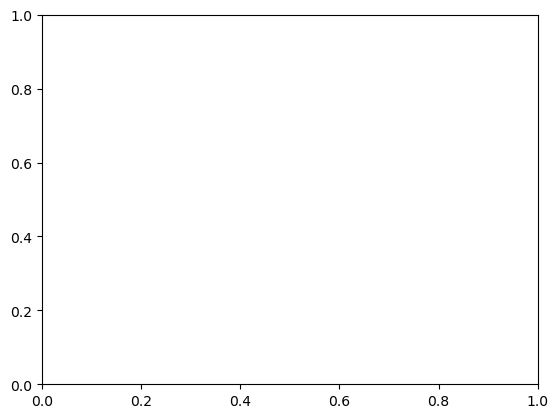

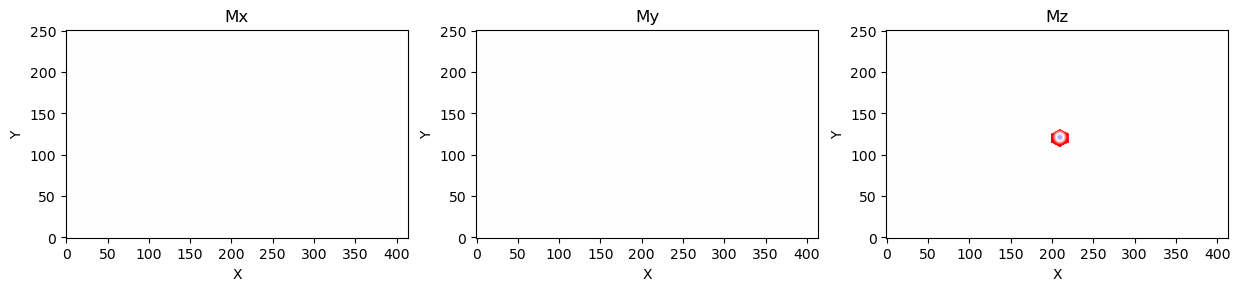

In [15]:
for i in range(NofP):
    mRes[i,:] = cp.asarray([0.,
			0.,
			300*((listX[i]-mPixelX/2-3)**2+(listY[i]-mPixelY/2+5)**2-20)/mPixelX/mPixelY])
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
	mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240712/mTarget.npy',mMat)
showM('20240712/mTarget.png')

In [56]:
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

In [ ]:
for distance in (48.,36.,24.,18.,12.,9.,6.,4.):
    matrixAGenerate(False)
    for i in range(NofP):
        mRes[i,:] = cp.asarray([0.,
			0.,
			120*((listX[i]-mPixelX/2-3)**2+(listY[i]-mPixelY/2+5)**2-20)/mPixelX/mPixelY])
    bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
    bCropped = cp.copy(bExp)
    bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    cp.save('2024071t/bX%s.npy'%(str(int(distance)).zfill(2)),bExp[:,:,0])
    cp.save('2024071t/bY%s.npy'%(str(int(distance)).zfill(2)),bExp[:,:,1])
    cp.save('2024071t/bZ%s.npy'%(str(int(distance)).zfill(2)),bExp[:,:,2])
    for i in range(5000):
        mRes = step(mRes,alpha=4,beta=3)
    for i in range(5000):
        mRes = step(mRes,alpha=0,beta=0)
    for i in range(5000):
        mRes = step(mRes,alpha=2,beta=2)
    for i in range(5000):
        mRes = step(mRes,alpha=0,beta=0)
    print(lossF(mRes))
    showM('2024071t/m%s.png'%(str(int(distance)).zfill(2)))
    showB('2024071t/B%s.png'%(str(int(distance)).zfill(2)))
    mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i],:] = mRes[i,:]
    cp.save('2024071t/mRes%s.npy'%(str(int(distance)).zfill(2)),mMat)

In [26]:
mT=np.load('20240712/mTarget.npy')
m04=np.load('20240711/mRes04.npy')
m06=np.load('20240711/mRes06.npy')
m09=np.load('20240711/mRes09.npy')
m12=np.load('20240711/mRes12.npy')
m18=np.load('20240711/mRes18.npy')
m24=np.load('20240711/mRes24.npy')
m36=np.load('20240711/mRes36.npy')
m48=np.load('20240711/mRes48.npy')

In [27]:
for i in [m04,m06,m09,m12,m18,m24,m36,m48]:
    print(np.sum((mT-i)**2)/np.sum(mT**2),np.sum(np.abs(mT-i))/np.sum(np.abs(mT)),corrP(i,mT,0.3),corrP(i,mT,0.5))

0.9680254054360969 1.6237092566722726 0.08708708708708708 0.30930930930930933
0.5745340511885223 1.1124647325194836 0.0990990990990991 0.5585585585585585
0.5212401161824498 0.9163609813347888 0.12612612612612611 0.6876876876876877
0.5147489722673211 0.8820196566031453 0.12612612612612611 0.6876876876876877
0.5917884385507992 0.9653365907001938 0.0960960960960961 0.6906906906906907
0.6577393890812475 1.0707956073480938 0.10810810810810811 0.5585585585585585
1.010092128891299 1.5735387025955543 0.03903903903903904 0.3063063063063063
2.3580204971921153 2.624701686839724 0.04804804804804805 0.14414414414414414


In [17]:
spinAllocate(0.32)

In [18]:
spinRegionSave('20240710/weight.npy')

In [9]:
spinRegionLoad()

TclError: can't invoke "wm" command: application has been destroyed